## Adding modules/packages is easy
* Make a base directory (~/py_packages) in which you will put your python code 
* Make a file called __init__.py in your base directory (contents can be empty)
* If, for example, ~/py_packages/name/code.py contains a function, fun1, then
    * **from** name **import** code
    * code.fun1()

Or, just to get started, cp -r /home/pangeo/py_packages ~

For a much more correct and concise discussion of packages, see:
[Ryan's Class page](https://rabernat.github.io/research_computing/organization-and-packaging-of-python-projects.html)

In [3]:
import os, sys
sys.path.append("/home2/nhn2/py_packages")  # substitute your username for nhn2
from ingrid import times

In [4]:
dir(times)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'enso2date',
 'to_pandas']

In [5]:
!cat ~/py_packages/ingrid/times.py | grep def

def to_pandas(Tgrid):
def enso2date(T0,ryear=1960,leap=True):


In [6]:
times.enso2date?

Signature: times.enso2date(T0, ryear=1960, leap=True)
Docstring: Print the date corresponding to an enso-time (months since 1960). The reference year can be changed.
File:      ~/py_packages/ingrid/times.py
Type:      function


In [7]:
times.enso2date(0.5), times.enso2date(4.5,ryear=2018)

('1/16/1960', '5/16/2018')

In [8]:
# Now lets use to_pandas to convert an ingrid time grid to datetime
import xarray as xr
ncfile = '/net/kage/d5/datasets/ORAs4/surface/zos.nc'
ds = xr.open_dataset(ncfile,decode_times=False)
ds

<xarray.Dataset>
Dimensions:  (T: 696, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * T        (T) float32 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5 -17.5 -16.5 ...
Data variables:
    zos      (T, lat, lon) float32 ...

In [9]:
if 'T' in list(ds.dims):
    ds = ds.rename({'T':'time'})
    
if 'units' in list(ds.time.attrs):
    if 'months since' in ds.time.units:
        ds['time'] = times.to_pandas(ds.time)
        
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 696)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * time     (time) datetime64[ns] 1958-01-16 1958-02-16 1958-03-16 ...
Data variables:
    zos      (time, lat, lon) float32 ...

In [10]:
# now that we have datetime, can compute anomalies:
anom = ds.zos.groupby('time.month') - ds.zos.groupby('time.month').mean('time')
anom.sel(lon=120,lat=20,method='nearest').plot()

In [11]:
from ingrid.code import call_ingrid
call_ingrid?

Signature: call_ingrid(ingridcode)
Docstring:
Call ingrid from python.

Example
-------
    import sys
    sys.path.append("/net/carney/home/naomi/mymodules")
    from ingrid.code import call_ingrid

    ingridcode = """
    \\begin{ingrid}
    %% comments need double percent
    SOURCES .WORLDBATH432 .bath
    (bath.nc)writeCDF 
    \\end{ingrid} 
    """

    call_ingrid(ingridcode)

Parameters
----------
    ingridcode : str
    A multiline string starting with \\begin{ingrid} and 
    ending with \\end{ingrid}
File:      ~/py_packages/ingrid/code.py
Type:      function


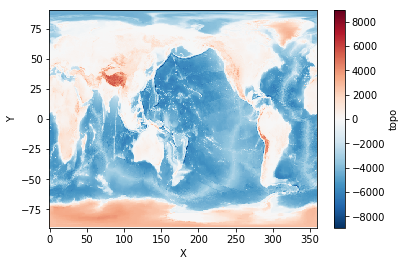

In [12]:
import xarray as xr
%matplotlib inline

ingridcode = """
\\begin{ingrid}
SOURCES .WORLDBATH432 .bath
/name (topo) def
(topography.nc)writeCDF 
\\end{ingrid} 
"""

call_ingrid(ingridcode)
ds = xr.open_dataset('topography.nc')
ds.topo.plot()